In [1]:
import torch
from jaxtyping import Int, Float
from typing import Tuple
from torch import Tensor
from timm.layers.helpers import to_2tuple
from torch import nn
from PIL import Image
import numpy as np
from torchvision.transforms.v2.functional import to_image, to_dtype, to_dtype_image


In [2]:
PATCH_SIZE = 16
IMG_SIZE = 224
MASK_RATIO = 0.5
img = Image.open("../../artifacts/img.jpg").resize((224, 224)).convert("RGB")
img = to_dtype_image(to_image(img), dtype=torch.float32, scale=True).unsqueeze(0)


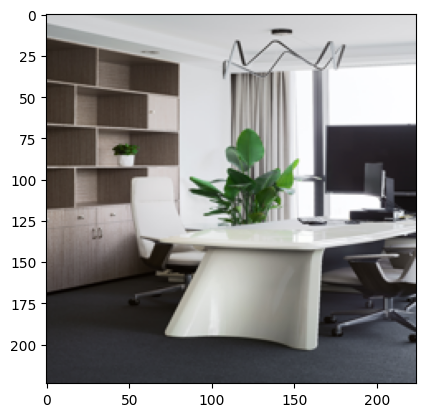

In [3]:
# plot image
import matplotlib.pyplot as plt
plt.imshow(img[0].permute(1, 2, 0))

In [4]:
import torch
import math
from torch import Tensor

def stratified_jittered_sampling(
    B: int,
    H: int,
    W: int,
    patch_size: int,
    N_vis: int,
    device: torch.device,
) -> tuple[Tensor, Tensor]:
    """
    Generate stratified jittered patch positions in a vectorized manner.
    
    Args:
        B: Batch size.
        H, W: Image height and width.
        patch_size: Size of each patch.
        N_vis: Number of visible patches to sample.
        device: Torch device.
        
    Returns:
        ys, xs: Tensors of shape [B, N_vis] with integer top-left coordinates.
    """
    valid_H = H - patch_size  # maximum valid y coordinate
    valid_W = W - patch_size  # maximum valid x coordinate

    # Determine grid dimensions for stratification.
    # We choose grid_rows such that grid_rows = floor(sqrt(N_vis)),
    # and grid_cols = ceil(N_vis / grid_rows) so that grid_rows * grid_cols >= N_vis.
    grid_rows = int(math.floor(math.sqrt(N_vis)))
    grid_cols = int(math.ceil(N_vis / grid_rows))
    cell_h = valid_H / grid_rows
    cell_w = valid_W / grid_cols

    # Create a meshgrid of cell indices.
    row_idx = torch.arange(grid_rows, device=device).float().unsqueeze(1)  # shape [grid_rows, 1]
    col_idx = torch.arange(grid_cols, device=device).float().unsqueeze(0)   # shape [1, grid_cols]
    
    # Generate random jitter for each cell.
    rand_y = torch.rand((grid_rows, grid_cols), device=device)
    rand_x = torch.rand((grid_rows, grid_cols), device=device)
    
    # Compute jittered coordinates within each cell.
    ys_grid = (row_idx + rand_y) * cell_h  # shape [grid_rows, grid_cols]
    xs_grid = (col_idx + rand_x) * cell_w  # shape [grid_rows, grid_cols]
    
    # Clamp coordinates to the valid range.
    ys_grid = torch.clamp(ys_grid, max=valid_H)
    xs_grid = torch.clamp(xs_grid, max=valid_W)
    
    # Flatten the grid.
    ys_flat = ys_grid.flatten()  # shape [grid_rows * grid_cols]
    xs_flat = xs_grid.flatten()  # shape [grid_rows * grid_cols]
    total_candidates = ys_flat.shape[0]  # equals grid_rows * grid_cols, which is >= N_vis

    # Always select N_vis indices without needing a conditional.
    perm = torch.randperm(total_candidates, device=device)[:N_vis]
    ys_sampled = ys_flat[perm].long()
    xs_sampled = xs_flat[perm].long()
    
    # Expand to batch size.
    ys_sampled = ys_sampled.unsqueeze(0).expand(B, -1)
    xs_sampled = xs_sampled.unsqueeze(0).expand(B, -1)
    return ys_sampled, xs_sampled

def stratified_jittered_sampling_per_batch(
    B: int,
    H: int,
    W: int,
    patch_size: int,
    N_vis: int,
    device: torch.device,
) -> tuple[Tensor, Tensor]:
    """
    Generate stratified jittered patch positions independently for each batch item.
    
    For each batch item, we:
      1. Divide the valid region ([0, H - patch_size] x [0, W - patch_size]) into a grid.
      2. Add random jitter to the grid cell centers.
      3. Flatten the candidate grid to get a list of candidate coordinates.
      4. For each batch item, select N_vis indices from its candidate grid.
    
    This yields a tensor of y coordinates and a tensor of x coordinates of shape [B, N_vis]
    with different values for each batch item.
    """
    valid_H = H - patch_size  # maximum valid top-left y
    valid_W = W - patch_size  # maximum valid top-left x

    # Determine grid dimensions such that grid_rows * grid_cols >= N_vis.
    grid_rows = int(math.floor(math.sqrt(N_vis)))
    grid_cols = int(math.ceil(N_vis / grid_rows))
    cell_h = valid_H / grid_rows
    cell_w = valid_W / grid_cols

    # Create a candidate grid per batch.
    # row_idx: shape [B, grid_rows, grid_cols]
    row_idx = torch.arange(grid_rows, device=device).float().unsqueeze(0).unsqueeze(2).expand(B, -1, grid_cols)
    # col_idx: shape [B, grid_rows, grid_cols]
    col_idx = torch.arange(grid_cols, device=device).float().unsqueeze(0).unsqueeze(1).expand(B, grid_rows, -1)
    
    # Generate random jitter for each batch independently.
    rand_y = torch.rand(B, grid_rows, grid_cols, device=device)
    rand_x = torch.rand(B, grid_rows, grid_cols, device=device)
    
    # Compute jittered candidate coordinates.
    ys_grid = (row_idx + rand_y) * cell_h
    xs_grid = (col_idx + rand_x) * cell_w
    
    # Clamp to valid range.
    ys_grid = torch.clamp(ys_grid, max=valid_H)
    xs_grid = torch.clamp(xs_grid, max=valid_W)
    
    # Flatten candidate grid per batch: shape [B, total_candidates]
    ys_flat = ys_grid.reshape(B, -1)
    xs_flat = xs_grid.reshape(B, -1)
    total_candidates = ys_flat.size(1)  # equals grid_rows * grid_cols
    
    # For each batch element, randomly select N_vis candidate indices.
    # Generate random scores per batch and sort.
    random_scores = torch.rand(B, total_candidates, device=device)
    sorted_indices = random_scores.argsort(dim=1)
    # Select the first N_vis indices for each batch.
    sel_indices = sorted_indices[:, :N_vis]
    
    # Gather the coordinates for each batch element.
    ys_sampled = torch.gather(ys_flat, 1, sel_indices).long()
    xs_sampled = torch.gather(xs_flat, 1, sel_indices).long()
    return ys_sampled, xs_sampled

def random_sampling(
    B: int, H: int, W: int, patch_size: int, N_vis: int, device: torch.device
) -> tuple[Int[Tensor, "B N"], Int[Tensor, "B N"]]:
    xs = torch.randint(0, W - patch_size, (B, N_vis), device=device)
    ys = torch.randint(0, H - patch_size, (B, N_vis), device=device)
    return ys, xs

In [ ]:
class OffGridPatcher(nn.Module):
    """
    Variant: Gather flattened patches and use a linear projection.
    """

    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_chans: int = 3,
        embed_dim: int = 768,
        sampler: callable = random_sampling,
        mask_ratio: float = 0.0,
    ) -> None:
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.patch_embed = LinearPatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_chans,
            embed_dim=embed_dim,
        )
        self.sampler = sampler
        self.mask_ratio = mask_ratio


    def _create_sampled_grid_flattened(
        self,
        patch_size: int,
        H: int,
        W: int,
        ys: Int[Tensor, "B N"],
        xs: Int[Tensor, "B N"],
    ) -> Int[Tensor, "B (N*P*P)"]:
        B, n_patches = ys.size(0), ys.size(1)
        dy = torch.arange(patch_size, device=ys.device).unsqueeze(1)
        dx = torch.arange(patch_size, device=ys.device).unsqueeze(0)
        d = (dy * W + dx).view(-1)
        base = ys * W + xs
        indices = base.unsqueeze(-1) + d.unsqueeze(0)
        return indices.view(B, n_patches * patch_size * patch_size)

    def forward(
        self, x: Float[Tensor, "B C H W"]
    ) -> tuple[Float[Tensor, "B N D"], Int[Tensor, "B N 2"]]:
        B, C, H, W = x.shape
        N = (H // self.patch_size) * (W // self.patch_size)
        N_vis = int(N * (1 - self.mask_ratio))
        ys, xs = self.sampler(B, H, W, self.patch_size, N_vis, x.device)
        patch_positions = torch.stack([ys, xs], dim=-1)
        patch_area = self.patch_size * self.patch_size
        indices = self._create_sampled_grid_flattened(self.patch_size, H, W, ys, xs)
        indices = indices.unsqueeze(1).expand(B, C, -1)
        patches_flat = x.flatten(-2).gather(2, indices)
        patches_flat = patches_flat.view(B, C, N_vis, patch_area)
        patches_flat = patches_flat.permute(0, 2, 1, 3).reshape(
            B, N_vis, C * patch_area
        )
        # patch_tokens = self.patch_embed(patches_flat)
        return patches_flat, patch_positions

    

class LinearPatchEmbed(nn.Module):
    """
    Linear patch embedding using nn.Unfold.
    Expects input patches of shape [B, num_patches, C*patch_size*patch_size].
    """

    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_channels: int = 3,
        embed_dim: int = 768,
    ) -> None:
        super().__init__()
        self.patch_size: int = patch_size
        self.embed_dim: int = embed_dim
        self.num_patches: int = (img_size // patch_size) ** 2
        self.proj = nn.Linear(patch_size * patch_size * in_channels, embed_dim)

    def forward(self, x: Float[Tensor, "B N (C P P)"]) -> Float[Tensor, "B N D"]:
        return self.proj(x)
    

class LinearPatchEmbedWithUnfold(nn.Module):
    """
    Linear patch embedding using nn.Unfold.
    """

    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_channels: int = 3,
        embed_dim: int = 768,
    ) -> None:
        super().__init__()
        self.patch_size: int = patch_size
        self.embed_dim: int = embed_dim
        self.num_patches: int = (img_size // patch_size) ** 2
        self.proj = nn.Linear(patch_size * patch_size * in_channels, embed_dim)

    def forward(self, x: Float[Tensor, "B C H W"]) -> Float[Tensor, "B N D"]:
        B, C, H, W = x.shape
        x_unf = nn.functional.unfold(x, self.patch_size, stride=self.patch_size)
        x_unf = x_unf.transpose(1, 2).reshape(B, C * self.patch_size * self.patch_size, -1)
        return self.proj(x_unf)
    


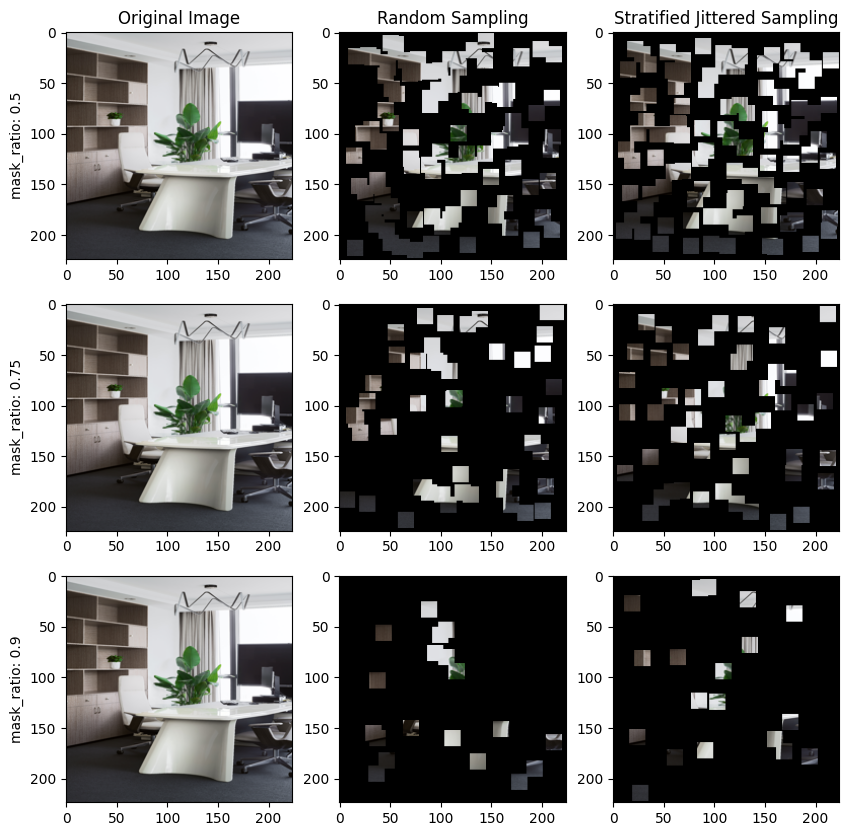

In [6]:
import torch
import torch
import matplotlib.pyplot as plt

def reconstruct_image_from_patches(
    patches: torch.Tensor,
    patch_positions: torch.Tensor,
    img_shape: tuple[int, int, int, int],
    patch_size: int,
) -> torch.Tensor:
    """
    Reconstruct an image from off-grid patches.
    
    Args:
        patches: Tensor of shape [B, N, C*patch_size*patch_size] (flattened patches).
        patch_positions: Tensor of shape [B, N, 2] giving (y, x) top-left coordinates.
        img_shape: The desired output image shape, e.g. (B, C, H, W).
        patch_size: The size of each patch (assumed square).
        
    Returns:
        A tensor of shape [B, C, H, W] with the patches pasted at the given positions.
    """
    B, C, H, W = img_shape
    reconstructed = torch.zeros(img_shape, device=patches.device, dtype=patches.dtype)
    N = patches.shape[1]
    # Reshape patches to [B, N, C, patch_size, patch_size]
    patches = patches.view(B, N, C, patch_size, patch_size)
    for b in range(B):
        for i in range(N):
            y, x = patch_positions[b, i]  # top-left coordinates
            # Paste patch into reconstructed image at (y, x)
            reconstructed[b, :, y:y+patch_size, x:x+patch_size] = patches[b, i]
    return reconstructed

# Sample image and patch extraction parameters.
P, img_size, C = 16, 224, 3
H, W = img_size, img_size



fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# add row titles
for ax, mask_ratio in zip(axes[:, 0], [0.5, 0.75, 0.9]):
    ax.set_ylabel(f"mask_ratio: {mask_ratio}")
# column titles
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Random Sampling")
axes[0, 2].set_title("Stratified Jittered Sampling")


# ROWS: mask_ratio: 0.5, 0.75, 0.9
for ax, mask_ratio in zip(axes, [0.5, 0.75, 0.9]):
    # COLS: 0: original, 1: random_sampling, 2: stratified_jittered_sampling
    ax[0].imshow(img[0].permute(1, 2, 0).detach().cpu().numpy())
    # ax[0].set_title("Original Image")

    # Random sampling
    patcher = OffGridPatcher(patch_size=P, mask_ratio=mask_ratio, sampler=random_sampling)
    patches, patch_positions = patcher(img)
    reconstructed_img = reconstruct_image_from_patches(patches, patch_positions, (1, C, H, W), patch_size=P)
    ax[1].imshow(reconstructed_img[0].permute(1, 2, 0).detach().cpu().numpy())
    # ax[1].set_title("Random Sampling")

    # Stratified jittered sampling
    patcher = OffGridPatcher(patch_size=P, mask_ratio=mask_ratio, sampler=stratified_jittered_sampling)
    patches, patch_positions = patcher(img)
    reconstructed_img = reconstruct_image_from_patches(patches, patch_positions, (1, C, H, W), patch_size=P)
    ax[2].imshow(reconstructed_img[0].permute(1, 2, 0).detach().cpu().numpy())
    # ax[2].set_title("Stratified Jittered Sampling")


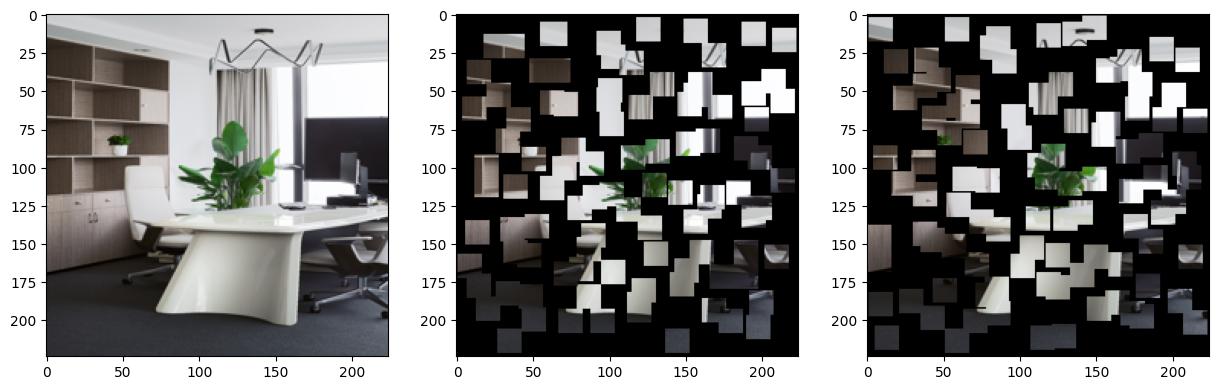

In [7]:

img_batch = torch.cat([img, img], dim=0)
patcher = OffGridPatcher(patch_size=P, mask_ratio=0.5, sampler=stratified_jittered_sampling_per_batch)
patches, patch_positions = patcher(img_batch)
# reconstructed_imgs = []
# for i in range(img_batch.size(0)):
#     reconstructed_img = reconstruct_image_from_patches(patches[i:i+1], patch_positions[i:i+1], (1, C, H, W), patch_size=P)
#     reconstructed_imgs.append(reconstructed_img)
 # reconstructed_imgs = torch.cat(reconstructed_imgs, dim=0)
reconstructed_imgs = reconstruct_image_from_patches(patches, patch_positions, (2, C, H, W), patch_size=P)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img[0].permute(1, 2, 0).detach().cpu().numpy())
axes[1].imshow(reconstructed_imgs[0].permute(1, 2, 0).detach().cpu().numpy())
axes[2].imshow(reconstructed_imgs[1].permute(1, 2, 0).detach().cpu().numpy())

In [9]:
grid_size = 14
grid_h = np.arange(grid_size, dtype=np.float32)
grid_w = np.arange(grid_size, dtype=np.float32)
grid = np.meshgrid(grid_w, grid_h)  # here w goes first
grid = np.stack(grid, axis=0)

In [12]:
from src.models.components.utils.offgrid_pos_embed import get_2d_sincos_pos_embed, get_canonical_coords, get_canonical_pos_embed
from src.models.components.utils.pos_embed import get_2d_sincos_pos_embed as get_2d_sincos_pos_embed_droppos

embed_dim = 16
grid_size = 14
patch_size = 16
coords = get_canonical_coords((grid_size, grid_size), patch_size)
m = get_2d_sincos_pos_embed(coords/patch_size, embed_dim)
# m = get_canonical_pos_embed(embed_dim, (grid_size, grid_size), patch_size).squeeze()
d = get_2d_sincos_pos_embed_droppos(embed_dim, grid_size)
d = torch.from_numpy(d).float()


torch.allclose(m, d, atol=1e-5)


True